In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
raw_data = pd.read_json("data/per_point_v2/ball_data_118.json").T.reset_index(names="frames").sort_values("frames")

data = raw_data.copy()
data["x"] = pd.to_numeric(data["x"], errors="coerce")
data["y"] = pd.to_numeric(data["y"], errors="coerce")
x0 = data["x"].dropna().iloc[0]
y0 = data["y"].dropna().iloc[0]

mask_change = (
    data["x"].notna() &
    data["y"].notna() &
    ((data["x"] != x0) | (data["y"] != y0))
)

first_move_idx = mask_change.idxmax()
data = data.loc[first_move_idx - 1:] 

In [14]:
vis = data[data.visible].copy()
vis["dt"] = vis.index.to_series().diff()
vis["dist"] = np.hypot(
    vis["x"].diff(),
    vis["y"].diff()
)
JUMP_THRESH = 300

jump_start_idx = vis[
    (vis["dt"] <= 2) &   # 1-frame gap OR 1-frame gap after nulls
    (vis["dist"] > JUMP_THRESH)
].index

if len(jump_start_idx) == 0:
    cleaned = data
else:
    clean_mask = pd.Series(True, index=data.index)

    for jump_frame in jump_start_idx:

        # Last good position BEFORE jump
        prev = vis.loc[:jump_frame].iloc[-2]
        x0, y0 = prev.x, prev.y

        # Frames AFTER jump
        after = vis.loc[jump_frame:]

        # Find when it comes back near original trajectory
        return_frame = None
        for f, r in after.iterrows():
            if np.hypot(r.x - x0, r.y - y0) < JUMP_THRESH:
                return_frame = f
                break

        if return_frame is None:
            # Remove everything after jump
            clean_mask.loc[jump_frame:] = False
        else:
            # Remove ghost segment
            clean_mask.loc[jump_frame:return_frame] = False

    data.loc[~clean_mask, ["x","y","visible"]] = [np.nan, np.nan, False]
    
    
MAX_JUMP = 300  
MAX_GAP = 10   

last_x, last_y, last_f = None, None, None
bad_rows = []

for f, row in data.iterrows():
    if not row["visible"]:
        continue

    if last_x is not None:
        dt = f - last_f
        dist = np.hypot(row["x"] - last_x, row["y"] - last_y)

        if dt > 1 and (dt <= MAX_GAP) and dist > MAX_JUMP:
            bad_rows.append(f)
            continue

    last_x, last_y, last_f = row["x"], row["y"], f

data.loc[bad_rows, ["x", "y", "visible"]] = [np.nan, np.nan, False]

In [15]:
data[["x", "y"]] = data[["x", "y"]].interpolate(limit_direction="both")
data = data.sort_values("frames")
from scipy.signal import savgol_filter

data["x_s"] = savgol_filter(data["x"], window_length=9, polyorder=2)
data["y_s"] = savgol_filter(data["y"], window_length=9, polyorder=2)
data["dx"] = data["x_s"].shift(-1) - data["x_s"]
data["dy"] = data["y_s"].shift(-1) - data["y_s"]

data[["dx", "dy"]] = data[["dx", "dy"]].bfill()

data["speed"] = (data["dx"] ** 2 + data["dy"] ** 2) ** 0.5

data["ax"] = data["dx"].shift(-1) - data["dx"]
data["ay"] = data["dy"].shift(-1) - data["dy"]

data[["ax", "ay"]] = data[["ax", "ay"]].bfill()

data["acceleration"] = (data["ax"] ** 2 + data["ay"] ** 2) ** 0.5

cols = ["dx", "dy", "speed", "ax", "ay", "acceleration"]

for c in cols:
    data[f"{c}_raw"] = data[c]

data[cols] = data[cols].rolling(5, center=True, min_periods=1).mean()

In [16]:
def dy_over_next_30_frames(row):
    frame = row["frames"]
    y = row["y"]
    next_y = data[(data.frames>frame) & (data.frames <= frame+30)]["y"]
    
    if len(next_y) > 0:
        return next_y.iloc[-1] - y
    else:
        return 0
data["dy_over_next_30"] = data.apply(dy_over_next_30_frames,axis=1)

def average_dy_over_next_10(row):
    frame = row["frames"]
    window = data[(data.frames >= frame) & (data.frames <= frame + 10)]
    return window.dy.mean()
data["average_dy_over_next_10"] = data.apply(average_dy_over_next_10,axis=1)

In [17]:
hits = data[data.action == "hit"]
bounces = data[data.action == "bounce"]

In [18]:
def local_max_in_dy_over_next_30(row, df):
    frame = row["frames"]
    dy_over_next_30_frames = row["dy_over_next_30"]
    
    window = df[(df.frames >= frame - 15) & (df.frames <= frame + 15)]
    
    if dy_over_next_30_frames == window.dy_over_next_30.max():
        return "max"
    elif dy_over_next_30_frames == window.dy_over_next_30.min():
        return "min"

In [19]:
upper_hits = data[(data["ay"] <= -5) & (data.dy_over_next_30 <= -150) & (data.average_dy_over_next_10 < 0) & (data.y > 500)] # good for top hits that make it over the net
upper_hits["extrema_in_dy_over_30"] = upper_hits.apply(local_max_in_dy_over_next_30,axis=1,args=(upper_hits,))
upper_hits = upper_hits[upper_hits.extrema_in_dy_over_30 == "min"]
upper_hits["hit_type"] = "upper"

lower_hits = data[(data["ay"] >= .5) & (data.dy_over_next_30 >= 150) & (data.average_dy_over_next_10 > 0) & (data.y < 500)] # good for bottom hits that make it over the net
lower_hits["extrema_in_dy_over_30"] = lower_hits.apply(local_max_in_dy_over_next_30,axis=1,args=(lower_hits,))
lower_hits = lower_hits[lower_hits.extrema_in_dy_over_30 == "max"]
#Correct lower hits
corrected_lower_hits = []
for i, lower_hit in lower_hits.iterrows():
    frame = lower_hit["frames"]
    before = data[(data.frames >= frame - 20) & (data.frames <= frame)]
    idx = before["y"].idxmin()
    min_y_before = data.loc[idx]
    corrected_lower_hits.append(min_y_before)
if len(corrected_lower_hits) > 0:
    lower_hits = pd.concat(corrected_lower_hits,axis=1).T
lower_hits["hit_type"] = "lower"

In [20]:
pred_hits = pd.concat([lower_hits,upper_hits]).sort_values("frames")

In [21]:
#First hit to find the serve that happens before
if len(pred_hits) > 0:
    if pred_hits.iloc[0].x == data.iloc[0].x and pred_hits.iloc[0].y == data.iloc[0].y:
        max_ay_before_first_hit = pd.Series()
    else:
        first_hit = pred_hits.iloc[0]
        if first_hit["hit_type"] == "lower":
            before_first_hit = data[(data.frames >= first_hit.frames - 50) & (data.frames <= first_hit.frames - 5) & (data.dy >= -2) & (data.dy <= 2)]
            max_ay_before_first_hit = before_first_hit.loc[before_first_hit.ay.idxmin()]
        else:
            before_first_hit = data[(data.frames >= first_hit.frames - 50) & (data.frames <= first_hit.frames - 5) & (data.dy >= -2) & (data.dy <= 2)]
            max_ay_before_first_hit = before_first_hit.loc[before_first_hit.ay.idxmin()]
        max_ay_before_first_hit["hit_type"] = "serve"    
        if np.abs(max_ay_before_first_hit.y - first_hit.y) <= 150:
            max_ay_before_first_hit = pd.Series()
else:
    max_ay_before_first_hit = pd.Series()
        

In [22]:
if len(max_ay_before_first_hit)>0:
    pred_hits = pd.concat([max_ay_before_first_hit.to_frame().T,pred_hits])

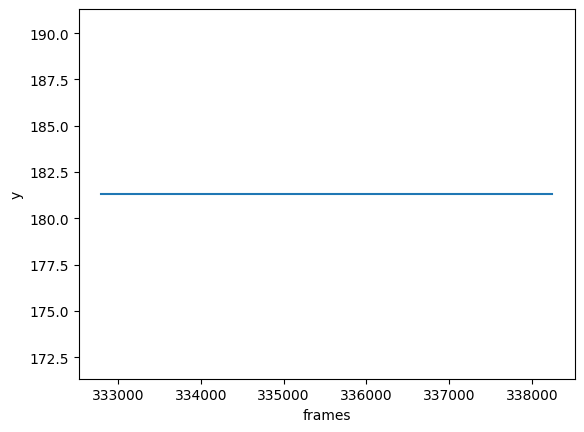

In [23]:
sns.lineplot(data=data,x="frames",y="y")

if len(pred_hits) > 0:
    if len(max_ay_before_first_hit) > 0:
        plt.axvline(max_ay_before_first_hit.frames, color='g', linestyle='--', alpha=0.7,  label='Hit')

In [24]:
# Find if there was a hit that hit the net
pred_hits["frame_gap"] = pred_hits.frames.diff()
pred_hits["group_id"] = (pred_hits["frame_gap"] > 300).cumsum()
pred_hits

,frames,x,y,visible,action,x_s,y_s,dx,dy,speed,...,speed_raw,ax_raw,ay_raw,acceleration_raw,dy_over_next_30,average_dy_over_next_10,extrema_in_dy_over_30,hit_type,frame_gap,group_id


In [25]:
bounces_between_hits = []
for gid, pred_hit_group in pred_hits.groupby("group_id"):
    for i  in range(pred_hit_group.shape[0] - 1):
        first_hit = pred_hit_group.iloc[i]
        second_hit = pred_hit_group.iloc[i+1]
        
        first_frame = first_hit.frames
        second_frame = second_hit.frames
        
        if second_frame - 5 - (first_frame + 5) < 3:
            continue
        between = data[(data.frames > first_frame + 5) & (data.frames < second_frame - 5)].copy()
        # between["ay_roll3"] = between["ay"].rolling(
        #     window=3,
        #     center=True,
        #     min_periods=3
        # ).mean()

        # get index of minimum rolling average
        idx = between["ay"].idxmin()

        # extract the CENTER row
        min_ay_between = between.loc[idx]
        bounces_between_hits.append(min_ay_between)


In [26]:
raw_data = raw_data.set_index("frames")
if len(bounces_between_hits) > 0:
    pred_bounces = pd.concat(bounces_between_hits,axis=1).T
    raw_data.loc[pred_bounces.frames,"pred_action"] = "bounce"  
            

raw_data.loc[pred_hits.frames, "pred_action"] = "hit"

raw_data["pred_action"] = raw_data["pred_action"].fillna("air")

raw_data = raw_data.reset_index()
raw_data["frames"] = raw_data["frames"].astype(str)

output = {
    row.frames: {
        "x": None if pd.isna(row.x) else int(row.x),
        "y": None if pd.isna(row.y) else int(row.y),
        "visible": bool(row.visible),
        "action": row.action,
        "pred_action": row.pred_action,
    }
    for _, row in raw_data.iterrows()
}

output

{'332800': {'x': 1079,
  'y': 181,
  'visible': True,
  'action': 'hit',
  'pred_action': 'air'},
 '332825': {'x': 736,
  'y': 600,
  'visible': True,
  'action': 'bounce',
  'pred_action': 'air'},
 '332866': {'x': 167,
  'y': 859,
  'visible': True,
  'action': 'hit',
  'pred_action': 'air'},
 '332913': {'x': 1115,
  'y': 402,
  'visible': True,
  'action': 'bounce',
  'pred_action': 'air'},
 '332937': {'x': 1201,
  'y': 247,
  'visible': True,
  'action': 'hit',
  'pred_action': 'air'},
 '332974': {'x': 710,
  'y': 721,
  'visible': True,
  'action': 'bounce',
  'pred_action': 'air'},
 '332990': {'x': 505,
  'y': 733,
  'visible': True,
  'action': 'hit',
  'pred_action': 'air'},
 '333029': {'x': 1087,
  'y': 398,
  'visible': True,
  'action': 'bounce',
  'pred_action': 'air'},
 '333051': {'x': 1145,
  'y': 281,
  'visible': True,
  'action': 'hit',
  'pred_action': 'air'},
 '333083': {'x': 738,
  'y': 670,
  'visible': True,
  'action': 'bounce',
  'pred_action': 'air'},
 '333108':

NameError: name 'pred_bounces' is not defined

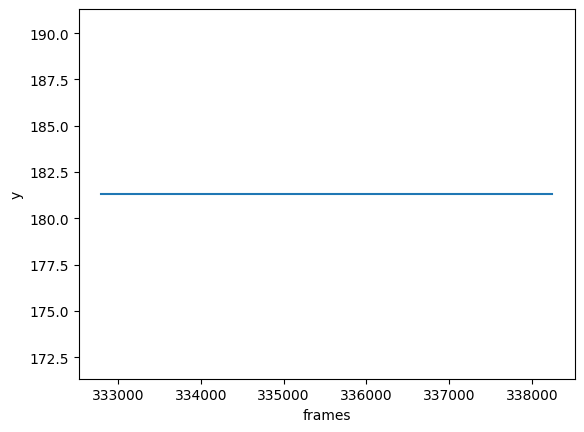

In [27]:
sns.lineplot(data=data,x="frames",y="y")

for h in pred_hits.frames:
    plt.axvline(h, color='g', linestyle='--', alpha=0.7,  label='Hit')
for b in pred_bounces.frames:
    plt.axvline(b, color='r', linestyle='--', alpha=0.7,  label='Hit')

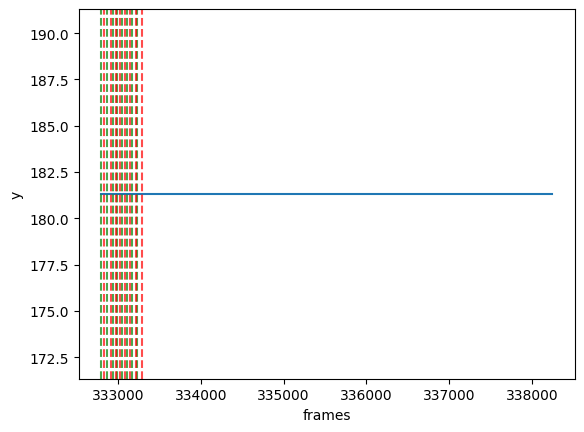

In [ ]:
sns.lineplot(data=data,x="frames",y="y")

for h in hits.frames:
    plt.axvline(h, color='g', linestyle='--', alpha=0.7,  label='Hit')
for b in bounces.frames:
    plt.axvline(b, color='r', linestyle='--', alpha=0.7,  label='Hit')

In [ ]:
frame = 312564
data[(data.frames >= frame -10) & (data.frames <= frame + 10)]

,frames,x,y,visible,action,x_s,y_s,dx,dy,speed,...,ay,acceleration,dx_raw,dy_raw,speed_raw,ax_raw,ay_raw,acceleration_raw,dy_over_next_30,average_dy_over_next_10
